In [1]:
# python env req:
# conda install -c conda-forge rubin-scheduler
# git clone ts_fbs_utils
# pip install -e . ts_fbs_utils --no-deps 
# git clone ts_config_ocs 
# find fbs_config_image_photocal_survey.py in ts_config_ocs/Scheduler/feature_scheduler/auxtel 

import os
import warnings
import copy
import pickle
import json
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
from cycler import cycler
import colorcet as cc

import pandas as pd

import datetime
from astropy.time import Time, TimeDelta
import astropy.units as u
import astropy
astropy.utils.iers.conf.iers_degraded_accuracy = 'ignore'

from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.utils import ra_dec2_hpid
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site
from rubin_scheduler.scheduler.features import Conditions
from rubin_scheduler.scheduler.schedulers import CoreScheduler
from rubin_scheduler.scheduler.utils import SchemaConverter

# Import the actually run config script from ts_config_ocs
# (run in directory containing a copy of the script)
from fbs_config_image_photocal_survey import get_scheduler

In [2]:
import hvplot.pandas
import panel as pn
import hvplot
import bokeh 

import schedview.compute
import schedview.compute.visits
import schedview.collect
import schedview.plot

In [3]:
# What night do you want? 
DAYOBS = '2024-04-03'
site = Site('LSST')
almanac = Almanac()
night_events = almanac.get_sunset_info(evening_date=DAYOBS, longitude=site.longitude_rad)
sunset = Time(night_events['sunset'], format='mjd', scale='utc') 
sunrise = Time(night_events['sun_n12_rising'], format='mjd', scale='utc')
survey_length = sunrise.mjd - sunset.mjd
sunset.iso, sunrise.iso, survey_length

('2024-04-03 22:32:27.047', '2024-04-04 10:04:06.675', 0.4803197658620775)

In [4]:
day_obs_mjd = int(Time(DAYOBS).mjd)
timezone = "Chile/Continental"
day_obs_datetime = Time(day_obs_mjd, format='mjd').datetime
day_obs_date = datetime.date(day_obs_datetime.year, day_obs_datetime.month, day_obs_datetime.day)
night_events = schedview.compute.astro.night_events(day_obs_date)

sunset = Time(night_events.loc['sun_n18_setting', 'MJD'], format='mjd', scale='utc')
sunrise = Time(night_events.loc['sun_n12_rising', 'MJD'], format='mjd', scale='utc')
survey_length = sunrise.mjd - sunset.mjd
print(sunset.iso, sunrise.iso, survey_length)
night_events

2024-04-03 23:55:52.405 2024-04-04 10:04:06.675 0.4223873824812472


,MJD,LST,UTC,Chile/Continental
event,,,,
sunset,60403.939202,100.105580,2024-04-03 22:32:27.047000+00:00,2024-04-03 19:32:27.047000-03:00
sun_n12_setting,60403.977841,114.053659,2024-04-03 23:28:05.446000+00:00,2024-04-03 20:28:05.446000-03:00
sun_n18_setting,60403.997134,121.018339,2024-04-03 23:55:52.405000+00:00,2024-04-03 20:55:52.405000-03:00
sun_n18_rising,60404.400208,266.522036,2024-04-04 09:36:17.943000+00:00,2024-04-04 06:36:17.943000-03:00
sun_n12_rising,60404.419522,273.494123,2024-04-04 10:04:06.675000+00:00,2024-04-04 07:04:06.675000-03:00
sunrise,60404.458218,287.462974,2024-04-04 10:59:50.046000+00:00,2024-04-04 07:59:50.046000-03:00
moonrise,60404.255211,214.180290,2024-04-04 06:07:30.224000+00:00,2024-04-04 03:07:30.224000-03:00
moonset,60404.838582,64.768963,2024-04-04 20:07:33.506000+00:00,2024-04-04 17:07:33.506000-03:00
night_middle,60404.198710,193.784278,2024-04-04 04:46:08.546000+00:00,2024-04-04 01:46:08.546000-03:00


In [5]:
start_times = np.arange(sunset, sunset + TimeDelta(2/24., format='jd'), TimeDelta(20*60, format='sec'))
print(len(start_times), start_times[0].iso)

7 2024-04-03 23:55:52.405


In [6]:
# Set up simulation with scheduler
# Keep this cell together (so regenerate scheduler and observatory if rerun)

rewards = False 

obs_examples = []
for start_time in start_times:
    nside, scheduler=get_scheduler()
    scheduler.keep_rewards=rewards
    
    observatory = ModelObservatory(nside=nside, mjd_start=start_time.mjd, downtimes="ideal", cloud_data="ideal")
    observatory.observatory.setup_camera(filter_changetime=5.0, maxspeed=1.5, shutter_2motion_min_time=0.0)
    observatory.observatory.setup_telescope(altitude_maxspeed=1.5, azimuth_maxspeed=1.5, settle_time=5.0)
    observatory.observatory.setup_dome(azimuth_maxspeed=3.0)
    
    vals = sim_runner(
        observatory,
        scheduler,
        survey_length=survey_length,
        record_rewards=rewards,
        verbose=True,
    )
    observatory = vals[0]
    scheduler = vals[1]
    observations = vals[2]
    if len(vals) == 5:
        rewards = vals[3]
        obs_rewards = vals[4]
    obs_examples.append(observations)

progress = 231.99%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 92 observations
ran in 0 min = 0.0 hours
progress = 228.70%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 90 observations
ran in 0 min = 0.0 hours
progress = 225.41%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 87 observations
ran in 0 min = 0.0 hours
progress = 222.13%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 85 observations
ran in 0 min = 0.0 hours
progress = 218.84%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 83 observations
ran in 0 min = 0.0 hours
progress = 215.55%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 81 observations
ran in 0 min = 0.0 hours
progress = 212.26%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 77 observations
ran in 0 min = 0.0 hours


In [7]:
print(np.diff(np.array([Time(o['mjd'][0], format='mjd', scale='utc').mjd for o in obs_examples]))*24*60)
[Time(o['mjd'][0], format='mjd', scale='utc').iso for o in obs_examples]

[19.98098406 19.96002053 20.0735107  20.00193374 19.91517079 20.01240636]


['2024-04-03 23:56:03.205',
 '2024-04-04 00:16:02.064',
 '2024-04-04 00:35:59.665',
 '2024-04-04 00:56:04.076',
 '2024-04-04 01:16:04.192',
 '2024-04-04 01:35:59.102',
 '2024-04-04 01:55:59.847']

In [1166]:
schema_converter = SchemaConverter()

def demangle_note(x):
    # remove _expnum
    x.target = copy.deepcopy(x.note)
    if "IM" in x.note:
        x.note = x.note.split(":")[1].split("_")[0]
    return x
    
visits_examples = []
for observations in obs_examples:
    visits = schema_converter.obs2opsim(observations)
    # add start_date
    visits["start_date"] = pd.to_datetime(visits["observationStartMJD"] + 2400000.5, 
                                          origin="julian", unit="D", utc=True)
    visits = visits.apply(demangle_note, axis=1)
    visits_examples.append(visits)

In [9]:
visits = visits_examples[0]
visits.head()

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,rotSkyPos_desired,numExposures,...,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,scripted_id,start_date
0,0,121.936108,-24.572558,60403.997259,0.000000,30.0,r,172.044265,0.0,4,...,13.228926,5.664700,311.981969,-22.096973,132.321217,109.348128,36.678570,8.378161,0,2024-04-03 23:56:03.205026090+00:00
1,1,307.075000,-87.472194,60403.999541,60404.024134,360.0,r,185.702282,0.0,1,...,13.231009,5.665571,312.027783,-22.086455,65.395356,94.639368,36.655561,182.213471,0,2024-04-03 23:59:20.309489073+00:00
2,2,192.068625,-44.718767,60404.004199,60404.030825,420.0,r,99.649749,0.0,1,...,13.235262,5.667348,312.121418,-22.065138,93.753431,140.935253,36.608558,127.847390,0,2024-04-04 00:06:02.767857310+00:00
3,3,86.500000,-32.306444,60404.011318,60404.036178,420.0,r,263.048274,0.0,1,...,13.241762,5.670064,312.264755,-22.032969,110.246776,79.077964,36.536667,-101.491756,0,2024-04-04 00:16:17.874881028+00:00
4,4,192.068625,-44.718767,60404.017634,60404.043297,420.0,r,96.824892,0.0,1,...,13.247529,5.672474,312.392153,-22.004845,93.955434,140.940096,36.472832,125.244282,0,2024-04-04 00:25:23.585379127+00:00


In [10]:
visits = visits_examples[1]
if len(visits):
    fig = bokeh.plotting.figure(frame_width=800)
    fig = schedview.plot.nightly.plot_alt_vs_time(
        visits=visits, almanac_events=night_events,
        figure=fig
    )
    bokeh.io.show(fig)
else:
    print("No visits")

In [11]:
if len(visits):
    fig = schedview.plot.nightly.plot_polar_alt_az(visits=visits, legend=True)
    bokeh.io.show(fig)
else:
    print("No visits")

In [12]:
def summarize_options(visits_examples):
    # Find what kinds of observations were present in all simulations
    all_notes = []
    for visits in visits_examples:
        all_notes.extend(list(visits.note.unique()))
    all_notes = set(all_notes)
    #print('Survey notes across all examples', all_notes)
    summary = {}
    summary['Observing'] = {}
    summary['Observing']['Start'] = []
    summary['Observing']["End"] = []
    summary['Observing']['Nobs'] = []
    for visits in visits_examples:
        summary['Observing']['Start'] += [visits.start_date.min()]
        summary['Observing']['End'] += [visits.start_date.max()]
        summary['Observing']['Nobs'] += [len(visits)]
    for note in all_notes:
        summary[note] = {}
    for note in all_notes:
        summary[note]["Start"] = []
        summary[note]["End"] = []
        summary[note]["Nobs"] = []
        summary[note]["Airmass Min"] = []
        summary[note]["Airmass Max"] = []
        for visits in visits_examples:
            subset = visits.query('note == @note')            
            summary[note]["Start"] += [subset.start_date.min()]
            summary[note]["End"] += [subset.start_date.max()]
            summary[note]["Nobs"] += [len(subset)]
            summary[note]["Airmass Min"] += [subset.airmass.min()]
            summary[note]["Airmass Max"] += [subset.airmass.max()]
    return pd.DataFrame(summary), all_notes

summary, notes = summarize_options(visits_examples)
summary

,Observing,cwfs,spec:HD111235,Photo0800-1,spec_bright:HD38666,spec:HD185975,spec:HD144334
Start,"[2024-04-03 23:56:03.205026090+00:00, 2024-04-...","[2024-04-03 23:56:03.205026090+00:00, 2024-04-...","[2024-04-04 00:06:02.767857310+00:00, 2024-04-...","[2024-04-04 02:38:23.738835454+00:00, 2024-04-...","[2024-04-04 00:16:17.874881028+00:00, 2024-04-...","[2024-04-03 23:59:20.309489073+00:00, 2024-04-...","[2024-04-04 03:48:35.290644768+00:00, 2024-04-..."
End,"[2024-04-04 09:54:40.031655727+00:00, 2024-04-...","[2024-04-04 08:14:26.463147106+00:00, 2024-04-...","[2024-04-04 09:46:57.775180932+00:00, 2024-04-...","[2024-04-04 03:26:45.161158741+00:00, 2024-04-...","[2024-04-04 02:30:21.483314038+00:00, 2024-04-...","[2024-04-04 09:54:40.031655727+00:00, 2024-04-...","[2024-04-04 09:38:44.968318638+00:00, 2024-04-..."
Nobs,"[92, 90, 87, 85, 83, 81, 77]","[5, 5, 5, 5, 5, 5, 4]","[29, 28, 26, 26, 25, 24, 23]","[24, 24, 24, 24, 24, 24, 24]","[8, 7, 6, 5, 4, 3, 1]","[7, 6, 6, 6, 6, 6, 5]","[19, 20, 20, 19, 19, 19, 20]"
Airmass Min,NaN,"[1.0050213406474164, 1.0069213506963046, 1.005...","[1.0332031615322455, 1.0331912489621253, 1.032...","[1.1922896146442608, 1.189854713243103, 1.1996...","[1.1933098802071387, 1.2305200423706137, 1.336...","[1.8727399057483665, 1.9128039855959438, 1.902...","[1.006749851974111, 1.0067546258574165, 1.0068..."
Airmass Max,NaN,"[1.4790621418394072, 1.8488935616033864, 1.845...","[2.0230966397999013, 2.12250910621292, 1.97286...","[1.3637401856872815, 1.3597919590860421, 1.377...","[2.0584590707792705, 2.0469344130859457, 2.066...","[2.1491676112718405, 2.1500636984457113, 2.149...","[1.7906108849233244, 1.7995463835409087, 1.828..."


In [13]:
summary.loc["Start", "Observing"][0], start_times[0].isot

(Timestamp('2024-04-03 23:56:03.205026090+0000', tz='UTC'),
 '2024-04-03T23:55:52.405')

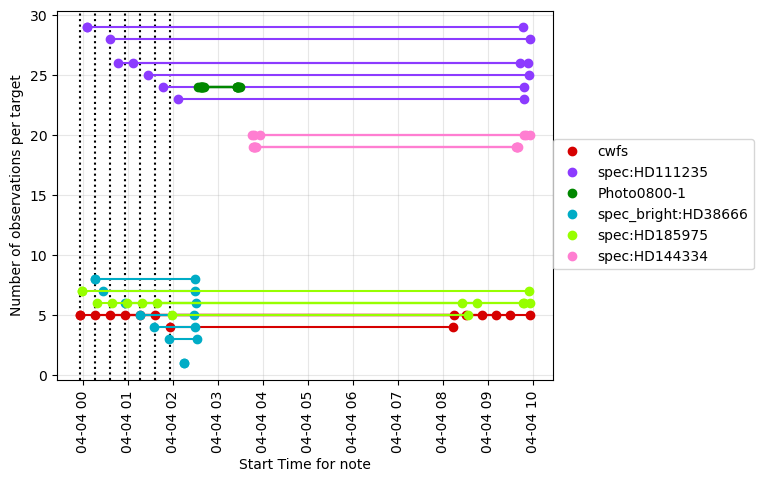

In [16]:
for time in summary.loc["Start", "Observing"]:
    plt.axvline(time, color='k', linestyle=':')
colors = cc.glasbey
for i, c in enumerate(notes):
    x1 = summary.loc['Start', c]
    x2 = summary.loc['End', c]
    y = summary.loc['Nobs', c]
    for xi, xo, yi in zip(x1, x2, y):
        plt.plot([xi, xo], [yi, yi], 
                 linestyle='-', marker='o', color=colors[i])
    plt.plot(summary.loc['Start', c][0], 
             summary.loc['Nobs', c][0], 
             linestyle='', marker='o', color=colors[i], label=c)
plt.xticks(rotation=90)
plt.xlabel("Start Time for note")
plt.ylabel("Number of observations per target")
plt.legend(loc=(1.0, 0.3))
plt.grid(True, alpha=0.3)

## Actual visits

In [2]:
import os
import warnings
import copy
import pickle
import json
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
from cycler import cycler
import colorcet as cc

import pandas as pd

import datetime
from astropy.time import Time, TimeDelta
import astropy.units as u
import astropy
astropy.utils.iers.conf.iers_degraded_accuracy = 'ignore'
import datetime

from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site
from rubin_scheduler.scheduler.features import Conditions
from rubin_scheduler.scheduler.schedulers import CoreScheduler
from rubin_scheduler.scheduler.utils import SchemaConverter


from lsst_efd_client import EfdClient
from lsst.resources import ResourcePath

from rubin_scheduler.scheduler.schedulers import CoreScheduler
from rubin_scheduler.scheduler.features import Conditions
from rubin_scheduler.site_models import Almanac

from urllib.parse import urlparse

os.environ["S3_ENDPOINT_URL"] = "https://s3dfrgw.slac.stanford.edu"
os.environ["LSST_DISABLE_BUCKET_VALIDATION"] = "1"
os.environ["AWS_PROFILE"] = "default"

bucket = "s3://rubin:"

efd_client = EfdClient('usdf_efd')

In [3]:
minutes_to_days = 1./60/24
seconds_to_days = 1./60/60/24

def demangle_note(x):    
    # remove _expnum
    x.target = copy.deepcopy(x.note)
    if "IM" in x.note:
        x.note = x.note.split(":")[1].split("_")[0]
    return x

In [4]:
def getDayObsStartTime(dayObs):
    """Get the start of the given dayObs as an astropy.time.Time object.

    The observatory rolls the date over at UTC-12.

    Parameters
    ----------
    dayObs : `int`
        The dayObs, as an integer, e.g. 20231225

    Returns
    -------
    time : `astropy.time.Time`
        The start of the dayObs as an astropy.time.Time object.
    """
    pythonDateTime = datetime.datetime.strptime(str(dayObs), "%Y%m%d")
    return Time(pythonDateTime) + 12 * u.hour

In [7]:
# What night do you want? 
DAYOBS = '2024-04-22'
site = Site('LSST')
almanac = Almanac()
night_events = almanac.get_sunset_info(evening_date=DAYOBS, longitude=site.longitude_rad)
sunset = Time(night_events['sunset'], format='mjd', scale='utc') 
sunrise = Time(night_events['sun_n12_rising'], format='mjd', scale='utc')
survey_length = sunrise.mjd - sunset.mjd
sunset.iso, sunrise.iso, survey_length

('2024-04-22 22:11:21.310', '2024-04-23 10:14:54.658', 0.5024693142622709)

In [8]:
# Fetch requested targets
topic = 'lsst.sal.Scheduler.logevent_target'
all_fields = await efd_client.get_fields(topic)
#print(all_fields)
targets = await efd_client.select_time_series(topic, all_fields, sunset, sunrise, index=2)

if len(targets) == 0:
    print(f"On night {DAYOBS} aux tel recorded {len(targets)} targets")

else:

    # target timestamp in EFD = time that the target is pushed to scriptqueue
    # this should be at the start of the previous observation
    targets["target_time"] = targets.index.copy()
    targets["target_mjd"] = Time(targets.index).mjd
    # estimate what time this target should be observed (start of observation)
    # == target_time + previous exposure time (?) + slew time
    cols = [c for c in targets if 'exposureTimes' in c]
    targets['total_exptime'] = targets[cols].sum(axis=1)
    previous_exposure_time = np.concatenate([np.array([0]), targets['total_exptime'][:-1]])
    # matches actual observation time better if we do not include previous observation time --
    # is target really being issued at start of previous observation, or end? 
    targets["target_obsmjd"] = Time(targets.index).mjd  + (targets['slewTime'])*seconds_to_days
    
    # mangle the note again 
    targets['orig_note'] = targets.note.copy()
    targets = targets.apply(demangle_note, axis=1)
    
    targets = targets.sort_values(by='target_obsmjd')
    targets['target_id'] = np.arange(0, len(targets), 1)
    targets = targets.reset_index(drop=True)
    
    print(f"On night {DAYOBS} aux tel recorded {len(targets)} targets for \n{targets.note.unique()}") 

On night 2024-04-22 aux tel recorded 90 targets for 
['cwfs' 'spec:HD111235' 'spec:HD185975' 'spec_bright:HD38666'
 'Photo0800-1' 'spec:HD144334' 'Photo1600-1' 'Target']


In [9]:
# Observations are the actually acquired observations .. 
#  ... likely be better to get this from butler or the consDB 

topic = 'lsst.sal.Scheduler.logevent_observation'
all_fields = await efd_client.get_fields(topic)
obs = await efd_client.select_time_series(topic, all_fields, sunset, sunrise, index=2)

if len(obs) == 0:
    print(f"On night {DAYOBS} aux tel recorded {len(obs)} observations")

else:
    # timestamp is the time of successful end of observation/JSON block
    obs['obs_time'] = obs.index.copy()
    obs['obs_obsmjd'] = Time(obs.index).mjd - (obs['exptime'] * seconds_to_days)
    
    obs = obs.sort_values(by='obs_obsmjd')
    obs['obs_id'] = np.arange(0, len(obs), 1)
    obs = obs.reset_index(drop=True)
    
    print(f"On night {DAYOBS} aux tel recorded {len(obs)} observations") 

On night 2024-04-22 aux tel recorded 78 observations


In [10]:
obs

,SchedulerID,additionalInformation,decl,exptime,filter,mjd,nexp,priority,private_efdStamp,private_identity,...,private_revCode,private_seqNum,private_sndStamp,ra,rotSkyPos,salIndex,targetId,obs_time,obs_obsmjd,obs_id
0,None,,-24.989135,30,r,0,4,None,1.713828e+09,Scheduler:2,...,3942145a,189,1.713828e+09,121.809569,133.211884,2,0,2024-04-22 23:26:46.373517+00:00,60422.976578,0
1,None,,-44.718767,420,r,0,1,None,1.713829e+09,Scheduler:2,...,3942145a,190,1.713829e+09,192.068625,348.720441,2,0,2024-04-22 23:36:39.917073+00:00,60422.978934,1
2,None,,-87.472194,360,r,0,1,None,1.713831e+09,Scheduler:2,...,3942145a,191,1.713831e+09,307.075000,277.472368,2,0,2024-04-23 00:15:16.738277+00:00,60423.006444,2
3,None,,-44.718767,420,r,0,1,None,1.713832e+09,Scheduler:2,...,3942145a,192,1.713832e+09,192.068625,359.359575,2,0,2024-04-23 00:24:19.012989+00:00,60423.012026,3
4,None,,-32.306444,420,r,0,1,None,1.713832e+09,Scheduler:2,...,3942145a,193,1.713832e+09,86.500000,19.413568,2,0,2024-04-23 00:31:19.196184+00:00,60423.016889,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,None,,-23.960829,120,g,0,1,None,1.713866e+09,Scheduler:2,...,3942145a,262,1.713866e+09,239.996109,24.242244,2,0,2024-04-23 09:46:01.786120+00:00,60423.405576,73
74,None,,-23.960829,120,g,0,1,None,1.713866e+09,Scheduler:2,...,3942145a,263,1.713866e+09,240.012276,24.310945,2,0,2024-04-23 09:49:58.070936+00:00,60423.408311,74
75,None,,-23.960829,120,g,0,1,None,1.713867e+09,Scheduler:2,...,3942145a,264,1.713867e+09,240.028484,24.387627,2,0,2024-04-23 10:02:53.414239+00:00,60423.417285,75
76,None,,-21.789144,30,r,0,4,None,1.713867e+09,Scheduler:2,...,3942145a,265,1.713867e+09,287.501270,168.999040,2,0,2024-04-23 10:05:19.282512+00:00,60423.420015,76


In [11]:
"""
time = np.linspace(obs.obs_obsmjd.min(), obs.obs_obsmjd.max(), num=len(obs))
plt.plot((time - time[0])/minutes_to_days, time - obs.obs_obsmjd.values, 'k.')

time = np.linspace(targets.target_obsmjd.min(), targets.target_obsmjd.max(), num=len(targets))
plt.plot((time - time[0])/minutes_to_days,  time - targets.target_obsmjd.values, 'r.', markersize=10)
plt.plot((time - time[0])/minutes_to_days, time - targets.target_mjd.values, 'b.')
"""

"\ntime = np.linspace(obs.obs_obsmjd.min(), obs.obs_obsmjd.max(), num=len(obs))\nplt.plot((time - time[0])/minutes_to_days, time - obs.obs_obsmjd.values, 'k.')\n\ntime = np.linspace(targets.target_obsmjd.min(), targets.target_obsmjd.max(), num=len(targets))\nplt.plot((time - time[0])/minutes_to_days,  time - targets.target_obsmjd.values, 'r.', markersize=10)\nplt.plot((time - time[0])/minutes_to_days, time - targets.target_mjd.values, 'b.')\n"

In [12]:
def match_obs_and_targets(obs, targets):
    # Check targets -> observations
    target_to_obs_match = np.zeros(len(targets), int)
    obs_to_target_match = np.zeros(len(obs), int)

    count = 0
    for i, (ri, t) in enumerate(targets.iterrows()):
        # Find the soonest observation which matches the same RA/Dec/filter
        # and which is not already matched, and is also not more than X minutes later
        # Let's just assume targets and obs are already sorted in start_mjd ... 
        # X needs to be adjusted so that the number of unmatched targets is correct
        target_error = 2.0 * minutes_to_days
        X = 28 * minutes_to_days
        match = np.where((t.target_obsmjd <= (obs.obs_obsmjd + target_error)) # close in time
                         & ((obs.obs_obsmjd - t.target_obsmjd) <= X) # not more than X
                         & (t.ra == obs.ra) 
                         & (t.decl == obs.decl) 
                         & (t['filter'] == obs['filter'])
                         & (obs_to_target_match == 0))[0]
        if len(match) == 0:
            print(f'no obs match for target {t.target_id}')
            count += 1
            target_to_obs_match[i] = -1
        else:
            # Consider target to have found the best match 
            # in the first (soonest) of 'match'
            idx = match[0]
            target_to_obs_match[i] = obs.iloc[idx]['obs_id']
            # And consider observation to have found a match
            obs_to_target_match[idx] = t['target_id']

    obs['target_id'] = np.array(obs_to_target_match)
    targets['obs_id'] = np.array(target_to_obs_match)
    
    print(f'failed to match {count} targets to observations')
    print(f'compare to {len(targets) - len(obs)} expected difference')
    return obs, targets

In [13]:
obs, targets = match_obs_and_targets(obs, targets)

no obs match for target 2
no obs match for target 52
no obs match for target 56
no obs match for target 57
no obs match for target 60
no obs match for target 62
no obs match for target 63
no obs match for target 67
no obs match for target 68
no obs match for target 86
no obs match for target 88
no obs match for target 89
failed to match 12 targets to observations
compare to 12 expected difference


In [14]:
# Join targets + obs
jj = obs.join(targets, on='target_id', lsuffix='_o', rsuffix='_t')
jj = jj.sort_values(by='obs_obsmjd')

jj['delta_obs'] = np.concatenate([np.array([0]), np.diff(jj['obs_obsmjd'])/minutes_to_days]) # minutes
jj['delta_request'] = (jj['obs_obsmjd'] - jj['target_obsmjd']) / minutes_to_days # minutes 


# expected time between observations should be slewtime + exposure time of previous target
# Note that in target -- total exposure time is split between exposures. 
# But in 'observation' -- total exposure time is already in exptime, and nexp means "to be split between nexp exposures".
prev_exposure_time = np.concatenate([np.array([0]), jj['exptime'][:-1]])
jj['expected_overhead'] = (prev_exposure_time + jj['slewTime'])/60 # minutes
#jj['expected_overhead'] = (jj['exptime'] + jj['slewTime'])/60

In [15]:
jj.columns

Index(['target_id', 'SchedulerID_o', 'additionalInformation', 'decl_o',
       'exptime', 'filter_o', 'mjd', 'nexp', 'priority_o',
       'private_efdStamp_o', 'private_identity_o', 'private_kafkaStamp_o',
       'private_origin_o', 'private_rcvStamp_o', 'private_revCode_o',
       'private_seqNum_o', 'private_sndStamp_o', 'ra_o', 'rotSkyPos',
       'salIndex_o', 'targetId_o', 'obs_time', 'obs_obsmjd', 'obs_id_o',
       'target_id_o', 'SchedulerID_t', 'airmass', 'cloud', 'decl_t',
       'exposureTimes0', 'exposureTimes1', 'exposureTimes2', 'exposureTimes3',
       'exposureTimes4', 'exposureTimes5', 'exposureTimes6', 'exposureTimes7',
       'exposureTimes8', 'exposureTimes9', 'filter_t', 'isSequence', 'moonAlt',
       'moonAz', 'moonDec', 'moonDistance', 'moonPhase', 'moonRa', 'note',
       'numExposures', 'numProposals', 'offsetX', 'offsetY', 'priority_t',
       'private_efdStamp_t', 'private_host', 'private_identity_t',
       'private_kafkaStamp_t', 'private_origin_t', 'priva

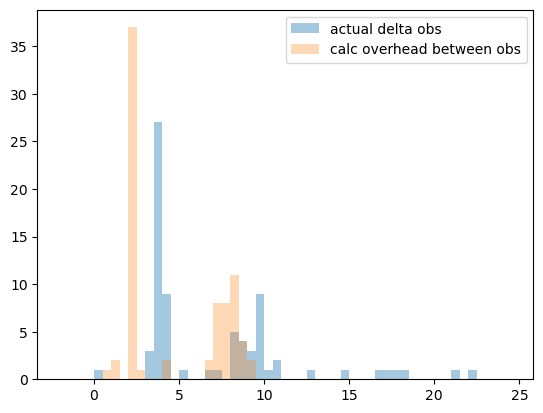

In [16]:
_ = plt.hist(jj['delta_obs'], bins=np.arange(-2, 25, 0.5), alpha=0.4, histtype='bar', label='actual delta obs')
_ = plt.hist(jj['expected_overhead'], bins=np.arange(-2, 25, 0.5), alpha=0.3, histtype='bar', label='calc overhead between obs')
#_ = plt.hist(jj['delta_request'], bins=np.arange(-2, 25, 0.5), alpha=0.3, histtype='bar', label='delta expected obs time')
plt.legend()

In [615]:
# Where did the time between observations just take longer than expected 
# delta obs compared to (slewTime + exptime) BUT sheduler target estimate was correct

overhead_error = 4 

overheads = np.where(jj.delta_obs - jj.expected_overhead > overhead_error)


breaks = []
for b in overheads[0]:
    b_start = jj.iloc[b-1]['obs_obsmjd'] + jj.iloc[b-1]['exptime']/60/60/24
    b_end = jj.iloc[b]['obs_obsmjd'] - jj.iloc[b]['slewTime']/60/60/24
    breaks.append([b_start, b_end])

print(len(overheads[0]))

11


Text(0, 0.5, 'Expected overhead (exptime + slew) (minutes)')

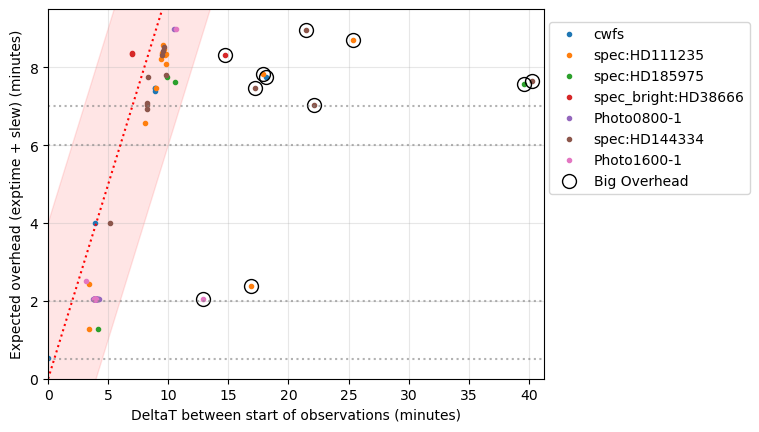

In [616]:
plt.figure()

eps = 1
for note in jj.note.unique():
    j = jj.query('note == @note')
    plt.plot(j.delta_obs, j.expected_overhead, '.', label=note)
j = jj.iloc[overheads]
plt.plot(j.delta_obs, j.expected_overhead, 'o',
         markersize=10, color='k', markerfacecolor='none', label='Big Overhead')
plt.legend(loc=(1.01, 0.5))
for exptime in jj.exptime.unique():
    plt.axhline(exptime/60, color='gray', linestyle=':', alpha=0.6)

x = np.arange(0, 60)
plt.plot(x, x, 'r:')
plt.fill_between(x, x-overhead_error, x+overhead_error,  color='r', alpha=0.1)
plt.grid(True, alpha=0.3)

plt.xlim(0, np.max(jj.delta_obs) + eps)
plt.ylim(0, np.max(jj.expected_overhead) + eps/2)

plt.xlabel("DeltaT between start of observations (minutes)")
plt.ylabel("Expected overhead (exptime + slew) (minutes)")

Text(0, 0.5, 'DeltaT between target request and observation (minutes)')

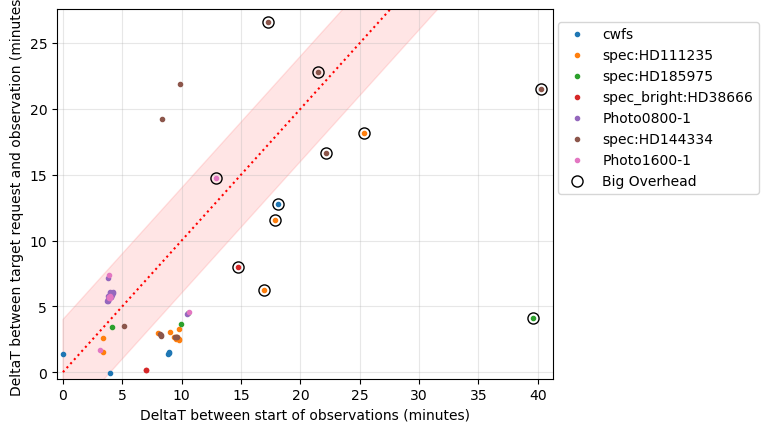

In [617]:
eps = 1
for note in jj.note.unique():
    j = jj.query('note == @note')
    plt.plot(j.delta_obs, j.delta_request, '.', label=note)

"""
for d in overheads:
    plt.plot([jj.delta_obs.iloc[d], jj.delta_obs.iloc[d-1]], 
             [jj.delta_request.iloc[d], jj.delta_request.iloc[d-1]],
             color='black', alpha=0.5, linestyle=':', zorder=0)
"""

j = jj.iloc[overheads]
plt.plot(j.delta_obs, j.delta_request, 'o', 
         markersize=8, color='k', markerfacecolor='none', label='Big Overhead')


plt.legend(loc=(1.01, 0.5))
x = np.arange(0, 60)
plt.plot(x, x, 'r:')
plt.fill_between(x, x-overhead_error, x+overhead_error,  color='r', alpha=0.1)
plt.grid(True, alpha=0.3)

plt.xlim(-0.5, np.max(jj.delta_obs) + eps)
plt.ylim(-0.5, np.max(jj.delta_request) + eps)

plt.xlabel("DeltaT between start of observations (minutes)")
plt.ylabel("DeltaT between target request and observation (minutes)")

Text(0, 0.5, 'airmass')

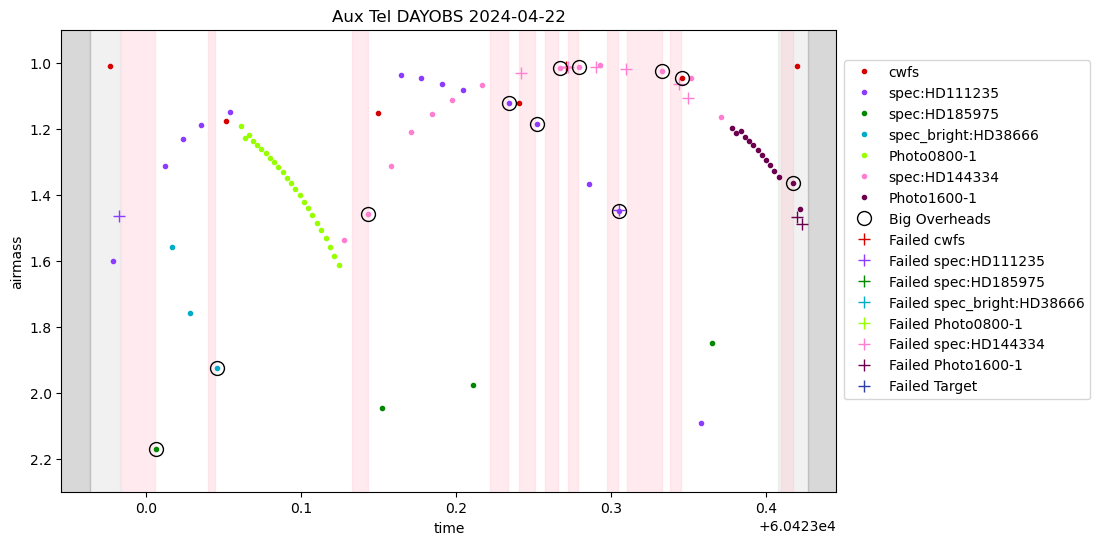

In [618]:
eps = 1
plt.figure(figsize=(10, 6))
plt.title(f"Aux Tel DAYOBS {DAYOBS}")


plt.fill_between([night_events['sun_n12_setting'], night_events['sun_n18_setting']],
                 2.5, 0.0, color='lightgray', alpha=0.3)
plt.fill_between([night_events['sunset'], night_events['sun_n12_setting']], 
                  2.5, 0.0, color='gray', alpha=0.3)
plt.fill_between([night_events['sun_n18_rising'], night_events['sun_n12_rising']],
                 2.5, 0.0, color='lightgray', alpha=0.3)
plt.fill_between([night_events['sun_n12_rising'], night_events['sunrise']],
                 2.5, 0.0, color='gray', alpha=0.3)

plt.axhline(night_events['moonrise'])

notes = jj.note.unique()
note_colors = {}
for i, n in enumerate(notes):
    note_colors[n] = cc.glasbey[i]

for note in jj.note.unique():
    j = jj.query('note == @note')
    plt.plot(j.obs_obsmjd, j.airmass, '.', color=note_colors[note], label=note)

if len(breaks) > 0:
    for b in breaks:
        plt.fill_between(b, 2.5, 0.0, color='pink', alpha=0.3)

j = jj.iloc[overheads]
plt.plot(j.obs_obsmjd, j.airmass, 'o', 
         markersize=10, color='k', markerfacecolor='none', label='Big Overheads')
#j = jj.iloc[overheads[0]+1]
#plt.plot(j.obs_obsmjd, j.airmass, 's', 
#         markersize=10, color='k', markerfacecolor='none', label='After Overhead?')

# Failed targets
i = len(cc.glasbey) - 1
for note in targets.note.unique():
    try:
        color = note_colors[note]
    except KeyError:
        color = cc.glasbey[i]
        i -= 1
    t = targets.query('note == @note and obs_id == -1')
    plt.plot(t.target_obsmjd, t.airmass, '+', markersize=9, 
             label=f'Failed {note}', color=color, zorder=1)


plt.legend(loc=(1.01, 0.2))

plt.xlim(night_events['sunset']+30/60/24, night_events['sunrise']-30/60/24)
plt.ylim(2.3, 0.9)

plt.xlabel("time")
#plt.xticks(rotation='vertical')
plt.ylabel("airmass")

In [624]:
fname = 'auxtel_2024-04-22.json'
rtv = pd.read_json(fname)
rtv.loc['Science program'].unique()

def demangle_target(x):
    if "Photo" in x.Target:
        x.note = x.Target.split("_")[0]
    if 'cwfs' in x["Science program"]:
        x.note = "cwfs"
    if 'HD1' in x.Target:
        x.note = f'spec:{x.Target}'
    if 'HD3' in x.Target:
        x.note = f'spec_bright:{x.Target}'
    return x

def get_mjdtime(x):
    # ok, the TAI time is ONLY the offset .. 
    qq = f'{x.dayObs} {x.TAI}'
    dtime = datetime.datetime.strptime(qq, '%Y%m%d %H:%M:%S')
    x['obsMjd'] = Time(dtime).mjd
    # So because it was only the offset, 
    # we have to do something dumb
    # (or go do proper queries in the butler)
    if x['obsMjd'] > sunrise.mjd:
        x['obsMjd'] -= 1
    if x['obsMjd'] < sunset.mjd:
        x['obsMjd'] += 1
    # Subtract half of the exposure time
    x['obsMjd'] -= x['Exposure time']/2*seconds_to_days
    return x

rtvT = rtv.T

rtvT['obsMjd'] = np.zeros(len(rtvT))
rtvT = rtvT.apply(get_mjdtime, axis=1)

rtvT['note'] = copy.deepcopy(rtvT.Target)
rtvT = rtvT.apply(demangle_target, axis=1)
print(rtvT['note'].unique())
rtvT.columns

['AzEl' 'DaytimeCheckout001' 'DaytimeCheckout002' 'FlatField position'
 'cwfs' 'HD  69755' 'spec:HD111235' '*   7 Leo' 'spec:HD185975'
 'spec_bright:HD38666' 'HD  77369' 'Photo0800-1' 'spec:HD144334'
 'HD 134574' 'HD 112563' 'HD 146284' 'Photo1600-1' 'HD 179609']


Index(['Exposure id', 'Exposure time', 'Darktime', 'Image type',
       'Observation reason', 'dayObs', 'seqNum', 'Group id', 'Target',
       'Science program', 'RA', 'Dec', 'Sky angle', 'Azimuth', 'Zenith angle',
       'TAI', 'Filter', 'Disperser', 'Airmass', 'Focus-Z', 'Altitude',
       'DIMM Seeing', 'Mount jitter RMS', 'Mount motion image degradation',
       '_Mount motion image degradation', '50-sigma source count',
       '_50-sigma source count', 'Mount timebase errors',
       '5-sigma source count', 'PSF FWHM', 'PSF e1', 'PSF e2', 'Sky mean',
       'Sky RMS', 'Variance plane mean', 'PSF star count', 'Astrometric bias',
       'Astrometric scatter', 'Zeropoint', '_5-sigma source count',
       '_PSF FWHM', '_PSF e1', '_PSF e2', '_Sky mean', '_Sky RMS',
       '_Variance plane mean', '_PSF star count', '_Astrometric bias',
       '_Astrometric scatter', '_Zeropoint', 'obsMjd', 'note'],
      dtype='object')

In [625]:
# Proper butler query - should work in RSP (?)
import lsst.summit.utils.butlerUtils as butlerUtils
butler = butlerUtils.makeDefaultLatissButler(embargo=True)

dayObs = 20240417
seqNum = 234

where = f"exposure.day_obs={dayObs} AND exposure.seq_num={seqNum} AND instrument='LATISS'"
(record, ) = butler.registry.queryDimensionRecords('exposure', where=where)
print(f"Exposure {record.id} was {record.exposure_time}s long and started at {record.timespan.begin}")

ModuleNotFoundError: No module named 'lsst.summit'

Text(0.5, 0, 'MJD')

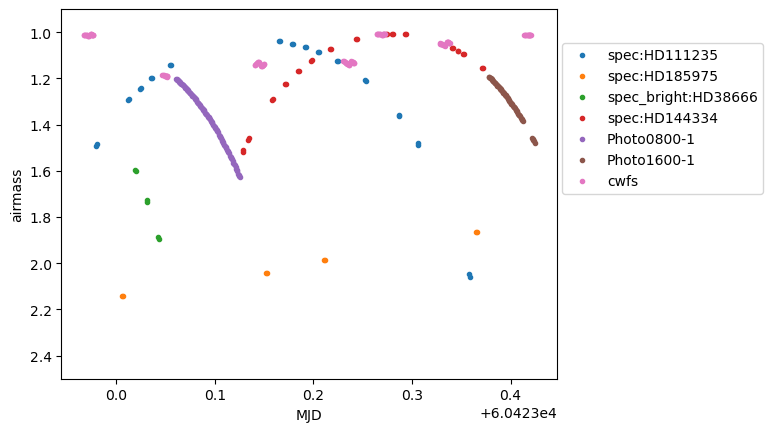

In [627]:
cond1 = np.where(rtvT['Observation reason'] == 'object')[0]
cond2 = np.where(rtvT['Observation reason'] == 'imaging')[0]
cond3 = np.where(rtvT['note'] == 'cwfs')[0]
sci = rtvT.iloc[np.concatenate([cond1, cond2, cond3])]
#sci = rtvT
for target in sci.note.unique():
    s = sci.query('note == @target')
    plt.plot(s['obsMjd'], s.Airmass, '.', label=target)
plt.legend(loc=(1.01, 0.5))
plt.ylim(2.5, 0.9)
plt.ylabel('airmass')
plt.xlabel('MJD')

Text(0, 0.5, 'airmass')

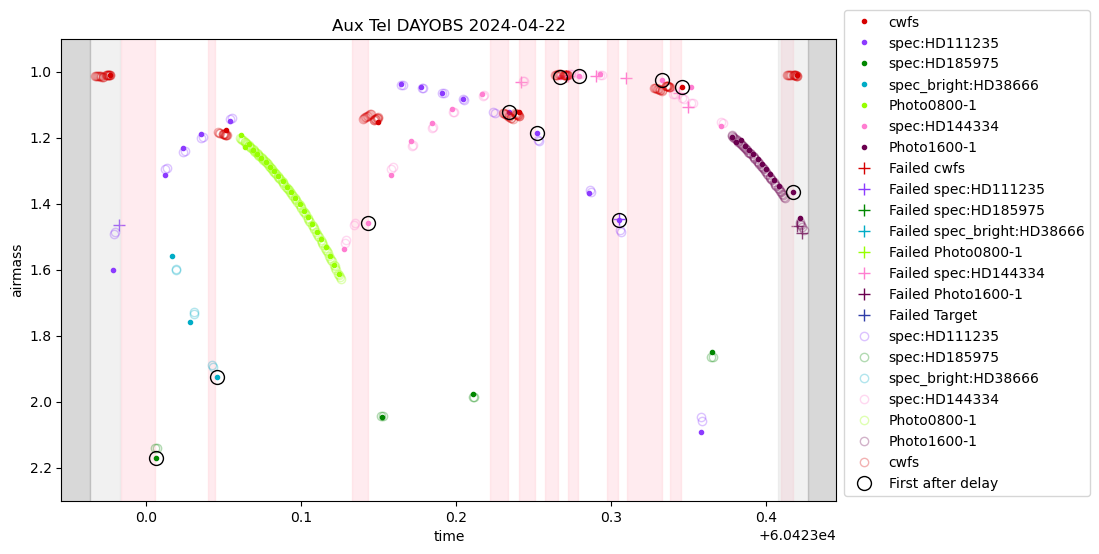

In [628]:
eps = 1
plt.figure(figsize=(10, 6))
plt.title(f"Aux Tel DAYOBS {DAYOBS}")

"""
plt.fill_between([night_events['sun_n12_setting'], night_events['sun_n18_setting']],
                 2.5, 0.0, color='lightgray', alpha=0.3)
plt.fill_between([night_events['sunset'], night_events['sun_n12_setting']], 
                  2.5, 0.0, color='gray', alpha=0.3)
plt.fill_between([night_events['sun_n18_rising'], night_events['sun_n12_rising']],
                 2.5, 0.0, color='lightgray', alpha=0.3)
plt.fill_between([night_events['sun_n12_rising'], night_events['sunrise']],
                 2.5, 0.0, color='gray', alpha=0.3)

plt.axhline(night_events['moonrise'])
"""

note_colors = {}
for i, n in enumerate(notes):
    note_colors[n] = cc.glasbey[i]
    
for note in jj.note.unique():
    j = jj.query('note == @note')
    plt.plot(j.obs_obsmjd, j.airmass, '.', color=note_colors[note], label=note)
# Failed targets
i = len(cc.glasbey) - 1
for note in targets.note.unique():
    try:
        color = note_colors[note]
    except KeyError:
        color = cc.glasbey[i]
        i -= 1
    t = targets.query('note == @note and obs_id == -1')
    plt.plot(t.target_obsmjd, t.airmass, '+', markersize=9, 
             label=f'Failed {note}', color=color, zorder=1)

for note in sci.note.unique():
    j = sci.query('note == @note')
    plt.plot(j.obsMjd, j.Airmass, 'o', color=note_colors[note], markerfacecolor='none', alpha=0.3, label=note)

if len(breaks) > 0:
    for b in breaks:
        plt.fill_between(b, 2.5, 0.0, color='pink', alpha=0.3)

j = jj.iloc[overheads]
plt.plot(j.obs_obsmjd, j.airmass, 'o', 
         markersize=10, color='k', markerfacecolor='none', label='First after delay')

plt.legend(loc=(1.01, 0.01))

plt.fill_between([night_events['sun_n12_setting'], night_events['sun_n18_setting']],
                 2.5, 0.0, color='lightgray', alpha=0.3)
plt.fill_between([night_events['sunset'], night_events['sun_n12_setting']], 
                  2.5, 0.0, color='gray', alpha=0.3)
plt.fill_between([night_events['sun_n18_rising'], night_events['sun_n12_rising']],
                 2.5, 0.0, color='lightgray', alpha=0.3)
plt.fill_between([night_events['sun_n12_rising'], night_events['sunrise']],
                 2.5, 0.0, color='gray', alpha=0.3)
plt.xlim(night_events['sunset']+30/60/24, night_events['sunrise']-30/60/24)
plt.ylim(2.3, 0.9)

plt.xlabel("time")
#plt.xticks(rotation='vertical')
plt.ylabel("airmass")

In [633]:
rtvT.query('note == "spec:HD111235" and obsMjd > 60423.3 and obsMjd < 60423.35' )

,Exposure id,Exposure time,Darktime,Image type,Observation reason,dayObs,seqNum,Group id,Target,Science program,...,_PSF e2,_Sky mean,_Sky RMS,_Variance plane mean,_PSF star count,_Astrometric bias,_Astrometric scatter,_Zeropoint,obsMjd,note
663,2024042200663,5.0,5.23911,acq,acq,20240422,663,2937863355640000,HD111235,spec-survey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60423.305214,spec:HD111235
664,2024042200664,5.0,5.23293,acq,acq,20240422,664,2937863355640000,HD111235,spec-survey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60423.305584,spec:HD111235
665,2024042200665,60.0,60.23830,science,object,20240422,665,2937863355640000,HD111235,spec-survey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60423.305648,spec:HD111235
666,2024042200666,60.0,60.25420,science,object,20240422,666,2937863355640000,HD111235,spec-survey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60423.306493,spec:HD111235
667,2024042200667,60.0,60.30260,science,x_offset_0,20240422,667,2937863361190000,HD111235,spec-survey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60423.307454,spec:HD111235
668,2024042200668,60.0,60.24400,science,x_offset_-50,20240422,668,2937866594090000,HD111235,spec-survey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60423.308426,spec:HD111235
669,2024042200669,60.0,60.22790,science,x_offset_50,20240422,669,2937867438120000,HD111235,spec-survey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60423.309410,spec:HD111235


In [623]:
# Get more recent scheduler snapshots
topic = "lsst.sal.Scheduler.logevent_largeFileObjectAvailable"
fields = ["url"]

dd = await efd_client.select_time_series(topic, fields, sunset, sunrise, index=2)
print(dd.url.iloc[0])
dd

https://s3.cp.lsst.org/rubinobs-lfa-cp/Scheduler:2/Scheduler:2/2024/04/22/Scheduler:2_Scheduler:2_2024-04-22T23:10:50.984.p


,url
2024-04-22 23:10:15.819373+00:00,https://s3.cp.lsst.org/rubinobs-lfa-cp/Schedul...
2024-04-22 23:26:16.545699+00:00,https://s3.cp.lsst.org/rubinobs-lfa-cp/Schedul...
2024-04-22 23:35:11.021632+00:00,https://s3.cp.lsst.org/rubinobs-lfa-cp/Schedul...
2024-04-22 23:38:50.622913+00:00,https://s3.cp.lsst.org/rubinobs-lfa-cp/Schedul...
2024-04-23 00:04:36.720182+00:00,https://s3.cp.lsst.org/rubinobs-lfa-cp/Schedul...
...,...
2024-04-23 09:42:13.338472+00:00,https://s3.cp.lsst.org/rubinobs-lfa-cp/Schedul...
2024-04-23 09:46:09.696161+00:00,https://s3.cp.lsst.org/rubinobs-lfa-cp/Schedul...
2024-04-23 10:02:56.504990+00:00,https://s3.cp.lsst.org/rubinobs-lfa-cp/Schedul...
2024-04-23 10:05:26.947234+00:00,https://s3.cp.lsst.org/rubinobs-lfa-cp/Schedul...


In [326]:
# for scheduler snapshots 
url = dd.url.iloc[0]
print(url)

bucket = "s3://rubin:"
uri = ResourcePath(bucket + urlparse(url).path.lstrip('/'))
uri

https://s3.cp.lsst.org/rubinobs-lfa-cp/Scheduler:2/Scheduler:2/2024/04/02/Scheduler:2_Scheduler:2_2024-04-02T23:57:55.593.p


ResourcePath("s3://rubin:rubinobs-lfa-cp/Scheduler:2/Scheduler:2/2024/04/02/Scheduler:2_Scheduler:2_2024-04-02T23:57:55.593.p")

In [327]:
res = uri.read()

In [333]:
scheduler, conditions = pickle.loads(res)
assert isinstance(scheduler, CoreScheduler)
assert isinstance(conditions, Conditions)

In [329]:
write = True
if write:
    for k in [res]:
        with open(f'pickles/snapshot_{k}.p', 'bw') as file:
            pickle.dump(snapshot_pickles[k], file)